In [1]:
import sys
sys.path.append('..')

# Load model

In [10]:
# Set the parameters to correspond to the loaded model
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=64, type=int, help="Batch size.")
parser.add_argument("--epochs", default=50, type=int, help="Number of epochs.")
parser.add_argument("--lr", default=1e-4, type=float, help="Learning rate.")
parser.add_argument("--loss_weight", action='store_true', help="Use weighted CE loss (Classes are inbalanced).")
parser.set_defaults(loss_weight=False)
parser.add_argument("--resnet", default='50', type=str, help="Resnet backbone version.")
parser.add_argument("--dim", default=512, type=int, help="Embedding dimnesion of CCT and CT.")
parser.add_argument("--cct_n_layers", default=2, type=int, help="Number of TransformerEncoderLayers in CCT.")
parser.add_argument("--cct_n_heads", default=4, type=int, help="Number attention heads in CCT.")
parser.add_argument("--cct_mlp_ratio", default=1.0, type=float, help="Sets size (relative to embedding dimension) of forward dimension of TransformerEncoderLayer in CCT.")
parser.add_argument("--num_heads", default=2, type=int, help="Number attention heads in CT.")
parser.add_argument("--expl_coeff", default=2.0, type=float, help="Influence of explanation loss (concepts prediction).")

args = parser.parse_args(args=[])

# checkpoint_path = '../logs/resnet_apy/2022-12-05_175746-bs=64,e=50,ec=2.0,lw=False,l=0.0001,nh=2,r=50/checkpoint/epoch=18-step=1691.ckpt'
# checkpoint_path = '../logs/ct_apy/2022-12-06_232159-bs=64,cmr=1.0,cnh=4,cnl=2,d=512,e=500,ec=2.0,lw=False,l=0.0001,nh=2/checkpoint/epoch=47-step=4272.ckpt'
checkpoint_path = '../logs/ct_apy/2022-12-06_232159-bs=64,cmr=1.0,cnh=4,cnl=2,d=512,e=500,ec=2.0,lw=False,l=0.0001,nh=2/checkpoint/last.ckpt'

In [11]:
import pytorch_lightning as pl

from ct.data.apy import aPY
from ct.model.ct_resnet_apy import CT_ResNet_aPY
from ct.model.ct_apy import CT_aPY

apy = aPY(batch_size=args.batch_size, data_path='../data')
model = CT_aPY(args)
model = model.load_from_checkpoint(checkpoint_path, args=args)

trainer = pl.Trainer(accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Test model

In [9]:
trainer.test(model=model, datamodule=apy)

Missing logger folder: /home/monhart.jakub/dd2412-project/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 90/90 [01:00<00:00,  1.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8127496838569641
      test_cls_loss         1.3040412664413452
     test_expl_loss         0.10282351076602936
        test_loss            1.509688138961792
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_cls_loss': 1.3040412664413452,
  'test_expl_loss': 0.10282351076602936,
  'test_acc': 0.8127496838569641,
  'test_loss': 1.509688138961792}]

In [12]:
trainer.test(model=model, datamodule=apy)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 90/90 [00:34<00:00,  2.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8124023079872131
      test_cls_loss          2.001408576965332
     test_expl_loss         0.09329384565353394
        test_loss           2.1879963874816895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_cls_loss': 2.001408576965332,
  'test_expl_loss': 0.09329384565353394,
  'test_acc': 0.8124023079872131,
  'test_loss': 2.1879963874816895}]

# Explore predictions

In [13]:
apy = aPY(batch_size=8, data_path='../data')
apy.setup()
id2class = apy.train.dataset.id2class
id2attribute = apy.train.dataset.id2attribute

# Concept threshold
c_th = 1e-1

test = iter(apy.test_dataloader())

In [25]:
batch = next(test)

pred_out = model.predict_step(batch, None)
image, target_class, target_concept, pred_class, attn = pred_out

target class:  bottle
predicted class:  bottle
target concepts:  ['Label' 'Glass']
predicted concepts:  ['Vert Cyl' 'Label' 'Glass']


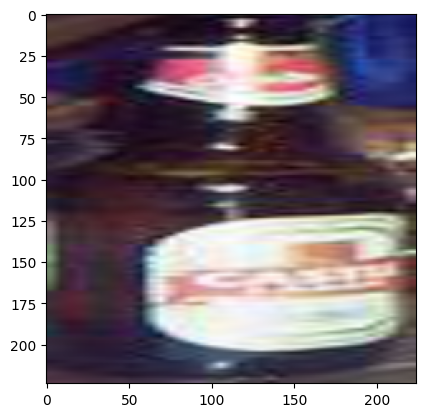

In [30]:
import matplotlib.pyplot as plt

idx = 4
plt.imshow(image[idx].permute(1, 2, 0))
print('target class: ', id2class[target_class[idx]])
print('predicted class: ', id2class[pred_class[idx]])
print('target concepts: ', id2attribute[target_concept[idx] == 1])
print('predicted concepts: ', id2attribute[attn[idx] > c_th])